In [709]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as spicystats
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_curve

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest


from sklearn.preprocessing import StandardScaler

sys.path.insert(0, '../src')
sys.path.insert(0, '../data')


import chess

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [688]:
# Read in chess dataset and sample it. Drop columns containing immaterial data.
chess_games = pd.read_csv("../data/games.csv")
chess_games.drop(['rated', 'id', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_eco'], axis=1, inplace=True)
chess_games.sample(10)

,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply
13517,43,resign,white,2232,1652,e4 c5 Nf3 Nc6 d4 cxd4 Nxd4 Nf6 Nc3 e5 Ndb5 a6 ...,Sicilian Defense: Lasker-Pelikan Variation,10
16031,51,resign,white,1393,1787,d4 d5 c4 Nf6 Nc3 Nc6 Nf3 Bg4 cxd5 e6 Qb3 Na5 Q...,Queen's Gambit Refused: Marshall Defense,4
1070,90,resign,black,1463,1974,e4 d5 Nf3 dxe4 Ng5 Nf6 d3 Bf5 Nc3 exd3 Bxd3 Bx...,Zukertort Opening: Tennison Gambit,3
15122,45,resign,white,1344,1195,e4 e5 Nf3 Bd6 Nc3 c5 Bc4 a6 d3 b5 Bd5 Nc6 a3 b...,King's Knight Opening,3
2721,92,resign,black,1150,1157,e4 e6 f4 d5 d3 c5 Nf3 Nf6 Nc3 Nc6 Be3 d4 Qd2 Q...,French Defense: La Bourdonnais Variation,3
19337,43,mate,white,2029,2117,e4 e5 Nf3 Nc6 Nc3 Nf6 Bb5 d6 d4 exd4 Nxd4 Bd7 ...,Four Knights Game: Spanish Variation,7
3800,57,resign,white,1857,1737,d4 Nf6 e3 d5 Nf3 c5 Bb5+ Bd7 Bxd7+ Nbxd7 dxc5 ...,Queen's Pawn Game: Colle System,5
8350,52,resign,black,1301,1571,e4 c5 Qf3 a6 Bc4 e6 d3 Nc6 Qg3 Nf6 Nf3 b5 Bb3 ...,Sicilian Defense,2
12377,48,resign,black,1684,1734,e4 e6 Nf3 d5 exd5 exd5 d4 Nf6 Bd3 Bg4 O-O Be7 ...,French Defense: Knight Variation,3
33,21,resign,black,1019,1500,d4 d5 c4 dxc4 e4 b5 Na3 a6 Qf3 f6 e5 fxe5 Qxa8...,Queen's Gambit Accepted: Central Variation | ...,6


In [689]:
victory_status = chess_games['victory_status'].value_counts()
victory_status

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

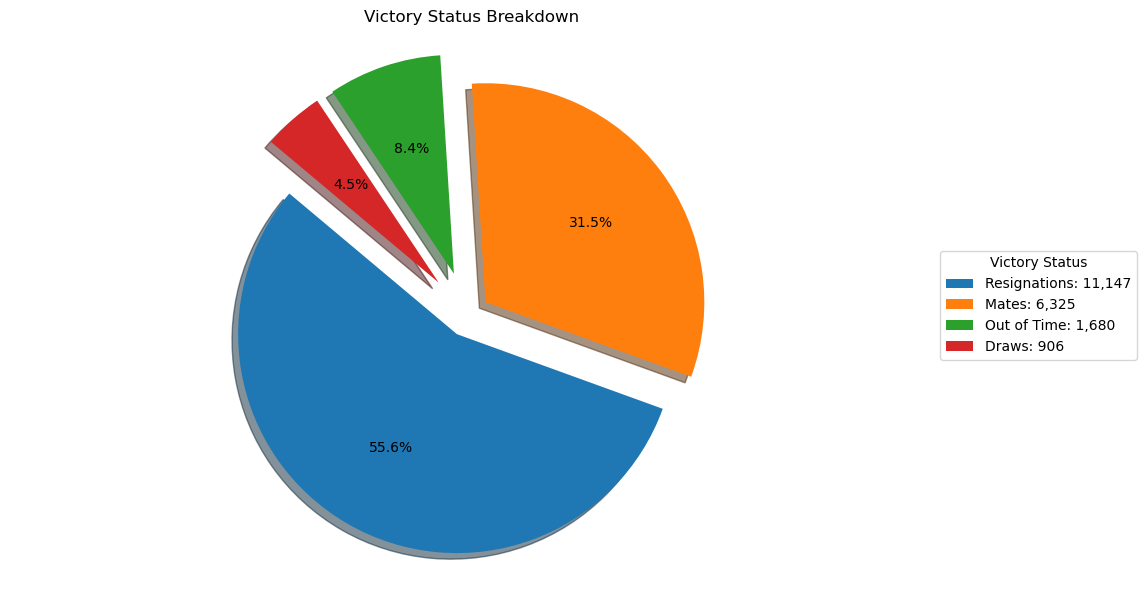

In [690]:
# Grab and count the chess victory status, broken down by category. Make pie chart to depict the delineations.

def chess_victories(chess_df):
     victory_status = chess_df['victory_status'].value_counts()

     fig, ax = plt.subplots(figsize = (10,6))

     sizes = victory_status.values
     labels = ['Resignations: 11,147', 'Mates: 6,325', 'Out of Time: 1,680', 'Draws: 906']
     explode = (0.1, 0.1, 0.2, 0.2)
     c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
     plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
     ax.legend( labels, title="Victory Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
     ax.set_title("Victory Status Breakdown")
     plt.tight_layout()
     plt.axis('equal')
     plt.show()
     return victory_status
victories_breakdown = chess_victories(chess_games)



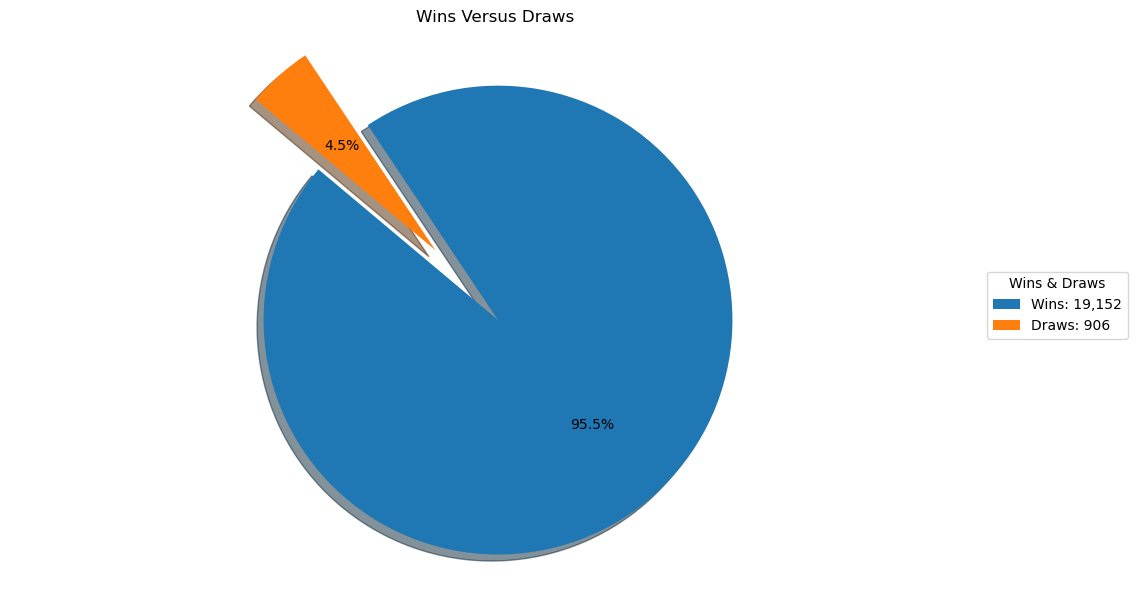

('95.48309901286271', '4.516900987137302')

In [691]:
# Look at games won, by mate, out of time, and resignation, and compare to draws. Make pie charts for both delineations. 

def wins_versus_losses(chess_df):
    game_status = chess_games['victory_status'].value_counts('draw')
    game_status_percent = game_status * 100
    victories_percent = str(sum(game_status_percent.iloc[:3]))
    draws_percent = str(sum(game_status_percent.iloc[-1:]))
    game_wins = sum(game_status.iloc[:3])
    game_draws = sum(game_status.iloc[-1:])
    
    fig, ax = plt.subplots(figsize = (10,6))

    sizes = victories_percent, draws_percent
    labels = ['Wins: 19,152', 'Draws: 906']
    explode = (0.2, 0.2)
    c = ['#1f77b4', '#ff7f0e']
    plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
    ax.legend(labels, title="Wins & Draws",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Wins Versus Draws")
    plt.tight_layout()
    plt.axis('equal')
    plt.show()
    return victories_percent, draws_percent
wins_versus_losses(chess_games)

In [ ]:
# Null Hypothesis: The rating differential between black and white has no significant impact on which player wins the game.
# Alternate Hypothesis: The rating differential between black and white has a significant impact on which player wins the game.

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\2239990673.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['victory_status'] = white_greater_100['victory_status'].apply(victory_status).astype(int)


(       turns  victory_status winner  white_rating  black_rating  \
 0         13               1  white          1500          1191   
 5          5               0   draw          1250          1002   
 9        119               1  white          1381          1209   
 10        39               1  white          1381          1272   
 19        25               1  white          1500          1094   
 ...      ...             ...    ...           ...           ...   
 20042     53               1  white          1759          1265   
 20044     37               1  white          1523          1256   
 20050      9               1  white          1243          1142   
 20053     24               1  white          1691          1220   
 20056    109               1  white          1360          1227   
 
                                                    moves  \
 0      d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...   
 5                                       e4 c5 Nf3 Qa5 a3   

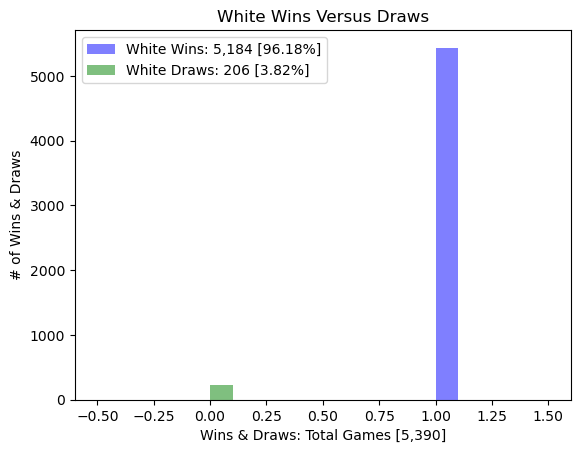

In [742]:
# Look at stronger white players, greater than 100 ELO, and map winning categories [mate, out of time, and resign] to 1 and draw category to 0.
# Perform t-test to analyze the p-value and ultimately the null & alternate hypotheses for white differentials.
# Histogram pot displaying white wins versus white draws when white is the superior opponent.

def chess_differentials_white(chess_df):
    chess_df = chess_df.copy()
    chess_df['Rating Differential White'] = (chess_df['white_rating'] - chess_df['black_rating']).astype(int)
    white_greater_100 = chess_df[chess_df['Rating Differential White'] > 100]
    
    
    def victory_status(s):
        if s == 'draw':
            return 0

        else:
            return 1
    white_greater_100['victory_status'] = white_greater_100['victory_status'].apply(victory_status).astype(int)
    
    white_ttest = spicystats.ttest_ind(white_greater_100['Rating Differential White'], white_greater_100['victory_status'], equal_var = False)
    
    fig,ax = plt.subplots()

    white_victory = white_greater_100[white_greater_100['victory_status'] == 1]
    white_draw = white_greater_100[white_greater_100['victory_status'] == 0]

    ax.hist(white_victory['victory_status'], color = 'b', alpha = 0.5, label = 'White Wins: 5,184 [96.18%]')
    ax.hist(white_draw['victory_status'], color = 'g', alpha = 0.5, label = 'White Draws: 206 [3.82%]')
    ax.set_title('White Wins Versus Draws')
    ax.set_ylabel('# of Wins & Draws')
    ax.set_xlabel('Wins & Draws: Total Games [5,390]')

    ax.legend();
    white_victory_counts = white_greater_100[white_greater_100['victory_status'] == 1].value_counts(normalize=True)
    white_draw_counts = white_greater_100[white_greater_100['victory_status'] == 0].value_counts(normalize=True)
    white_win_percentage = (5184 /(5184+206))*100
    white_draw_percentage = (206 /(5184+206))*100
    return white_greater_100, white_ttest, white_victory_counts, white_draw_counts, white_win_percentage, white_draw_percentage

chess_outcomes_white = chess_differentials_white(chess_games)
chess_outcomes_white

# The p-value is less than 0.05, so we reject the null hypothesis and there is significant difference, or impact, 
# between the white rating differentials, with white being the superior opponent, and who wins the game.
# White wins 96.18% of the time and draws 3.82% of the time over 5,390 games.



C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\1100696220.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['victory_status'] = black_greater_100['victory_status'].apply(victory_status).astype(int)


(       turns  victory_status winner  white_rating  black_rating  \
 7          9               1  black          1413          2108   
 11        38               1  black          1381          1867   
 12        60               1  black          1381          1936   
 13        31               1  black          1381          1607   
 18       101               1  black          1094          1300   
 ...      ...             ...    ...           ...           ...   
 20036     43               1  white          1247          1436   
 20038     36               1  black          1247          1359   
 20040     87               1  black          1261          1461   
 20041     58               1  black          1263          1770   
 20057     78               1  black          1235          1339   
 
                                                    moves  \
 7                         e4 Nc6 d4 e5 d5 Nce7 c3 Ng6 b4   
 11     e4 e6 d4 d5 e5 c5 c3 Nc6 Nf3 Qb6 Be3 Qxb2 Nbd2...   

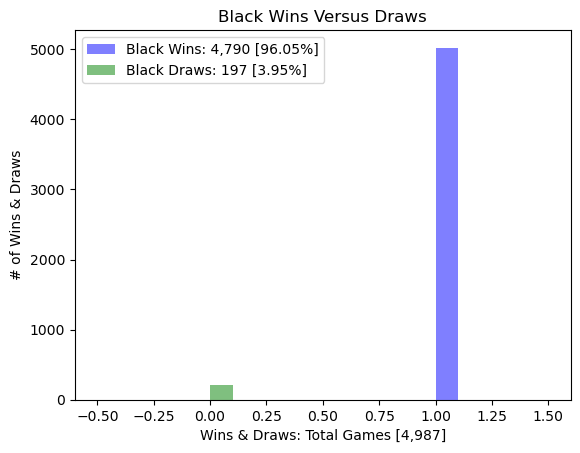

In [741]:
# Look at stronger black players, greater than 100 ELO, and map winning categories [mate, out of time, and resign] to 1 and draw category to 0.
# Perform t-test to analyze the p-value and ultimately the null & alternate hypotheses for black differentials.
# Histogram pot displaying black wins versus black draws when black is the superior opponent.

def chess_differentials_black(chess_df):
    chess_df = chess_df.copy()
    chess_df['Rating Differential Black'] = (chess_df['black_rating'] - chess_df['white_rating']).astype(int)
    black_greater_100 = (chess_df[chess_df['Rating Differential Black'] > 100])

    def victory_status(s):
        if s == 'draw':
            return 0

        else:
            return 1
    black_greater_100['victory_status'] = black_greater_100['victory_status'].apply(victory_status).astype(int)
    
    black_ttest = spicystats.ttest_ind(black_greater_100['Rating Differential Black'], black_greater_100['victory_status'], equal_var = False)
    
    fig,ax = plt.subplots()
    
    black_victory = black_greater_100[black_greater_100['victory_status'] == 1]
    black_draw = black_greater_100[black_greater_100['victory_status'] == 0]
    
    ax.hist(black_victory['victory_status'], color = 'b', alpha = 0.5, label = 'Black Wins: 4,790 [96.05%]')
    ax.hist(black_draw['victory_status'], color = 'g', alpha = 0.5, label = 'Black Draws: 197 [3.95%]')
    ax.set_title('Black Wins Versus Draws')
    ax.set_ylabel('# of Wins & Draws')
    ax.set_xlabel('Wins & Draws: Total Games [4,987]')

    ax.legend();
    black_victory_counts = black_greater_100[black_greater_100['victory_status'] == 1].value_counts()
    black_draw_counts = black_greater_100[black_greater_100['victory_status'] == 0].value_counts()
    black_win_percentage = (4790 /(4790+197))*100
    black_draw_percentage = (197 /(4790+197))*100

    return black_greater_100, black_ttest, black_victory_counts, black_draw_counts, black_win_percentage, black_draw_percentage
chess_outcomes_black = chess_differentials_black(chess_games)
chess_outcomes_black
# The p-value is less than 0.05, so we reject the null hypothesis and there is significant difference, or impact, 
# between the black rating differentials, with black being the superior opponent, and who wins the game.
# Black wins 96.05% of the time and draws 3.95% of the time over 4,987 games.

In [699]:
# Perform nonlinear Spearman correlation to see potential correlations between rating differentals, fow hwite and black respectively, and their victory status.
def chess_correlations_spearman(white, black):
    white_correlation_spearman = white['Rating Differential White'].corr(white['victory_status'], method ='spearman')

    black_correlation_spearman = black['Rating Differential Black'].corr(black['victory_status'], method ='spearman')

    return white_correlation_spearman, black_correlation_spearman
chess_correlations = chess_correlations_spearman(chess_differentials_white(chess_games), chess_differentials_black(chess_games))
chess_correlations

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\785227593.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['victory_status'] = white_greater_100['victory_status'].apply(victory_status).astype(int)
C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\2971413880.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['victory_status'] = black_greater_100['victory_status'].apply(victory_status).astype(int)


(0.005051227522468715, 0.05171853990117713)

In [700]:
# Null Hypothesis: The rating differential between black and white has no significant impact on which player wins the game.
# Alternate Hypothesis: The rating differential between black and white has a significant impact on which player wins the game.

KeyError: 'Rating Differential White'